# QuickDraw Sketch Classifier Training

## Imports and Configuration

In [1]:
import os
import time
import random
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from datetime import datetime

DATA_DIR = "quickdraw_images_dedup"
TMP_DATA_DIR = "quickdraw_images_100per"
IMG_SIZE = (128, 128)
BATCH_SIZE = 64
EPOCHS = 30
SEED = 42
OUTPUT_MODEL = "quickdraw_scratch_final.keras"
BEST_CHECKPOINT = "best_scratch_ckpt.keras"

MIXUP_ALPHA = 0.2
LABEL_SMOOTHING = 0.1
L2_WEIGHT = 1e-4
DROPOUT = 0.3

WARMUP_EPOCHS = 2
BASE_LR = 1e-3
MIN_LR = 1e-7

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print(f"[INFO] TensorFlow version: {tf.__version__}")
print(f"[INFO] GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

[INFO] TensorFlow version: 2.10.0
[INFO] GPU available: True


## Dataset Preparation

In [2]:
if not os.path.isdir(DATA_DIR):
    raise FileNotFoundError(f"Data directory '{DATA_DIR}' not found")

label_dirs = sorted([d for d in os.listdir(DATA_DIR) 
                     if os.path.isdir(os.path.join(DATA_DIR, d))])
if not label_dirs:
    raise RuntimeError(f"No label subdirectories found in '{DATA_DIR}'")

def count_images(root):
    counts = {}
    total = 0
    for class_name in sorted(os.listdir(root)):
        class_path = os.path.join(root, class_name)
        if not os.path.isdir(class_path):
            continue
        n_images = sum(1 for f in os.listdir(class_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg')))
        counts[class_name] = n_images
        total += n_images
    return counts, total

if os.path.exists(TMP_DATA_DIR):
    try:
        shutil.rmtree(TMP_DATA_DIR)
    except Exception:
        pass
os.makedirs(TMP_DATA_DIR, exist_ok=True)

MAX_PER_CLASS = 2500

for class_name in label_dirs:
    src_dir = os.path.join(DATA_DIR, class_name)
    dst_dir = os.path.join(TMP_DATA_DIR, class_name)
    os.makedirs(dst_dir, exist_ok=True)
    imgs = [f for f in os.listdir(src_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    imgs = sorted(imgs)
    if len(imgs) == 0:
        continue
    if len(imgs) <= MAX_PER_CLASS:
        chosen = imgs
    else:
        random.seed(SEED)
        chosen = imgs.copy()
        random.shuffle(chosen)
        chosen = chosen[:MAX_PER_CLASS]
    for fname in chosen:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(dst_dir, fname)
        if os.path.exists(dst):
            continue
        try:
            os.symlink(os.path.abspath(src), os.path.abspath(dst))
        except Exception:
            try:
                shutil.copy2(src, dst)
            except Exception:
                pass

class_counts, total_images = count_images(TMP_DATA_DIR)
print(f"[INFO] Using temporary dataset '{TMP_DATA_DIR}' with {len(class_counts)} classes, {total_images:,} total images")

[INFO] Using temporary dataset 'quickdraw_images_100per' with 26 classes, 65,000 total images


## Data Loading (80:10:10 Split)

In [3]:
print("[INFO] Loading datasets...")

raw_train = keras.utils.image_dataset_from_directory(
    TMP_DATA_DIR,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset='training',
    seed=SEED,
    shuffle=True
)

raw_val_test = keras.utils.image_dataset_from_directory(
    TMP_DATA_DIR,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    shuffle=False
)

class_names = raw_train.class_names
NUM_CLASSES = len(class_names)
print(f"[INFO] Classes: {NUM_CLASSES}")

AUTOTUNE = tf.data.AUTOTUNE
train_steps = int(tf.data.experimental.cardinality(raw_train).numpy())
val_test_steps = int(tf.data.experimental.cardinality(raw_val_test).numpy())

val_steps = val_test_steps // 2
test_steps = val_test_steps - val_steps

raw_val = raw_val_test.take(val_steps)
raw_test = raw_val_test.skip(val_steps)

print(f"[INFO] Train steps: {train_steps}, Val steps: {val_steps}, Test steps: {test_steps}")

[INFO] Loading datasets...
Found 65000 files belonging to 26 classes.
Using 52000 files for training.
Found 65000 files belonging to 26 classes.
Using 13000 files for validation.
[INFO] Classes: 26
[INFO] Train steps: 813, Val steps: 102, Test steps: 102


## Data Preprocessing and Augmentation

In [4]:
def augment_batch(images, labels):
    images = tf.cast(images, tf.float32)
    labels = tf.cast(labels, tf.float32)
    images = images / 255.0
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_brightness(images, 0.1)
    images = tf.image.random_contrast(images, 0.9, 1.1)
    images = tf.clip_by_value(images, 0.0, 1.0)
    return images, labels

def preprocess_val_batch(images, labels):
    images = tf.cast(images, tf.float32) / 255.0
    labels = tf.cast(labels, tf.float32)
    return images, labels

train_ds = raw_train.map(augment_batch, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds = raw_val.map(preprocess_val_batch, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
test_ds = raw_test.map(preprocess_val_batch, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

def apply_mixup(images, labels):
    batch_size = tf.shape(images)[0]
    alpha = MIXUP_ALPHA
    d1 = tf.random.gamma([batch_size], alpha, 1.0)
    d2 = tf.random.gamma([batch_size], alpha, 1.0)
    lam = tf.cast(d1 / (d1 + d2), tf.float32)
    lam_img = tf.reshape(lam, [batch_size, 1, 1, 1])
    lam_lbl = tf.reshape(lam, [batch_size, 1])
    idx = tf.random.shuffle(tf.range(batch_size))
    return lam_img * images + (1 - lam_img) * tf.gather(images, idx), \
           lam_lbl * labels + (1 - lam_lbl) * tf.gather(labels, idx)

if MIXUP_ALPHA > 0:
    train_ds = train_ds.map(apply_mixup, num_parallel_calls=AUTOTUNE)

## Model Architecture

In [5]:
def build_model(input_shape=IMG_SIZE + (3,), num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding='same', kernel_regularizer=regularizers.l2(L2_WEIGHT))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, padding='same', kernel_regularizer=regularizers.l2(L2_WEIGHT))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, 3, padding='same', kernel_regularizer=regularizers.l2(L2_WEIGHT))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(DROPOUT * 0.3)(x)
    x = layers.Conv2D(128, 3, padding='same', kernel_regularizer=regularizers.l2(L2_WEIGHT))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, 3, padding='same', kernel_regularizer=regularizers.l2(L2_WEIGHT))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(DROPOUT * 0.5)(x)
    x = layers.Conv2D(256, 3, padding='same', kernel_regularizer=regularizers.l2(L2_WEIGHT))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, 3, padding='same', kernel_regularizer=regularizers.l2(L2_WEIGHT))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(DROPOUT)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(L2_WEIGHT))(x)
    x = layers.Dropout(DROPOUT * 0.5)(x)
    x = layers.Dense(num_classes)(x)
    outputs = layers.Activation('softmax', dtype='float32')(x)
    return keras.Model(inputs, outputs, name='quickdraw_cnn')

print("[INFO] Building model...")
model = build_model()
model.summary()

[INFO] Building model...
Model: "quickdraw_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)          

## Model Training

In [6]:
optimizer = keras.optimizers.Adam(learning_rate=BASE_LR)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(
        label_smoothing=LABEL_SMOOTHING,
        from_logits=False
    ),
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_acc')]
)

try:
    counts_arr = np.array([class_counts.get(name, 1) for name in class_names])
    median = np.median(counts_arr)
    class_weights = {i: float(median / max(counts_arr[i], 1)) for i in range(NUM_CLASSES)}
    print(f"[INFO] Using class weights")
except:
    class_weights = None

callbacks = [
    keras.callbacks.ModelCheckpoint(
        BEST_CHECKPOINT,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=MIN_LR,
        verbose=1
    )
]

print(f"\n{'='*70}")
print(f"TRAINING START - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"{'='*70}\n")

start = time.time()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

elapsed = time.time() - start
print(f"\n[INFO] Training completed in {elapsed/60:.2f} minutes")

[INFO] Using class weights

TRAINING START - 2025-12-13 08:00:05

Epoch 1/30
813/813 [==============================] - ETA: 0s - loss: 2.2878 - accuracy: 0.4975 - top3_acc: 0.7389
Epoch 1: val_accuracy improved from -inf to 0.51930, saving model to best_scratch_ckpt.keras
813/813 [==============================] - 203s 227ms/step - loss: 2.2878 - accuracy: 0.4975 - top3_acc: 0.7389 - val_loss: 2.0239 - val_accuracy: 0.5193 - val_top3_acc: 0.8248 - lr: 0.0010
Epoch 2/30
812/813 [============================>.] - ETA: 0s - loss: 1.8701 - accuracy: 0.6910 - top3_acc: 0.8748
Epoch 2: val_accuracy did not improve from 0.51930
813/813 [==============================] - 85s 103ms/step - loss: 1.8702 - accuracy: 0.6910 - top3_acc: 0.8748 - val_loss: 3.1067 - val_accuracy: 0.2771 - val_top3_acc: 0.4988 - lr: 0.0010
Epoch 3/30
813/813 [==============================] - ETA: 0s - loss: 1.7478 - accuracy: 0.7429 - top3_acc: 0.9001
Epoch 3: val_accuracy did not improve from 0.51930
813/813 [======

In [ ]:
# Save training history for future use
import pickle

history_file = 'training_history.pkl'
with open(history_file, 'wb') as f:
    pickle.dump(history.history, f)
print(f"[INFO] Training history saved to {history_file}")

## Final Evaluation on Test Set

In [7]:
print("\n[INFO] Loading best model...")
if os.path.exists(BEST_CHECKPOINT):
    model = keras.models.load_model(BEST_CHECKPOINT)

print("[INFO] Final evaluation on test set...")
results = model.evaluate(test_ds, verbose=1, return_dict=True)

print(f"\n{'='*70}")
print("FINAL TEST RESULTS")
print(f"{'='*70}")
for name, value in results.items():
    print(f"  {name:20s}: {value:.4f}")
print(f"{'='*70}")

model.save(OUTPUT_MODEL)
print(f"\n[INFO] Saved: {OUTPUT_MODEL}")

best_val_acc = max(history.history['val_accuracy'])
print(f"\n[SUMMARY]")
print(f"  Classes: {NUM_CLASSES}")
print(f"  Images: {total_images:,}")
print(f"  Time: {elapsed/60:.2f} minutes")
print(f"  Best val accuracy: {best_val_acc:.4f}")
print(f"  Final test accuracy: {results['accuracy']:.4f}")
print(f"\nDONE! {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


[INFO] Loading best model...
[INFO] Final evaluation on test set...
102/102 [==============================] - 16s 83ms/step - loss: 1.0254 - accuracy: 0.9346 - top3_acc: 0.9762

FINAL TEST RESULTS
  loss                : 1.0254
  accuracy            : 0.9346
  top3_acc            : 0.9762

[INFO] Saved: quickdraw_scratch_final.keras

[SUMMARY]
  Classes: 26
  Images: 65,000
  Time: 56.98 minutes
  Best val accuracy: 0.9438
  Final test accuracy: 0.9346

DONE! 2025-12-13 08:57:22


NameError: name 'history' is not defined

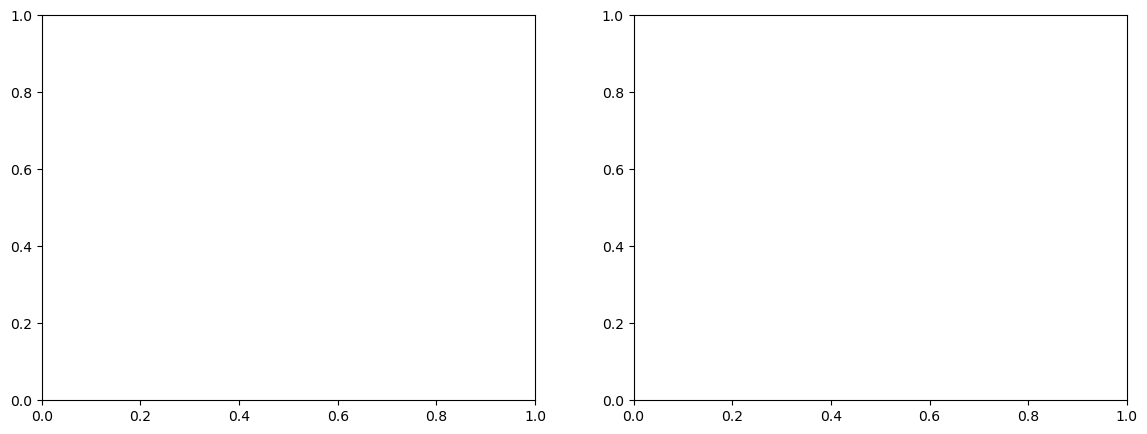

In [1]:
# Plot training history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Load training history from saved file (if needed)
# Uncomment these lines if you need to reload history after closing VSCode

# import pickle
# with open('training_history.pkl', 'rb') as f:
#     history_dict = pickle.load(f)
# 
# # Then use history_dict instead of history.history in the plotting code below

## Plot Training History (Alternative: Load from Saved File)

## Visualization of Test Predictions

1/1 [==============================] - 1s 591ms/step


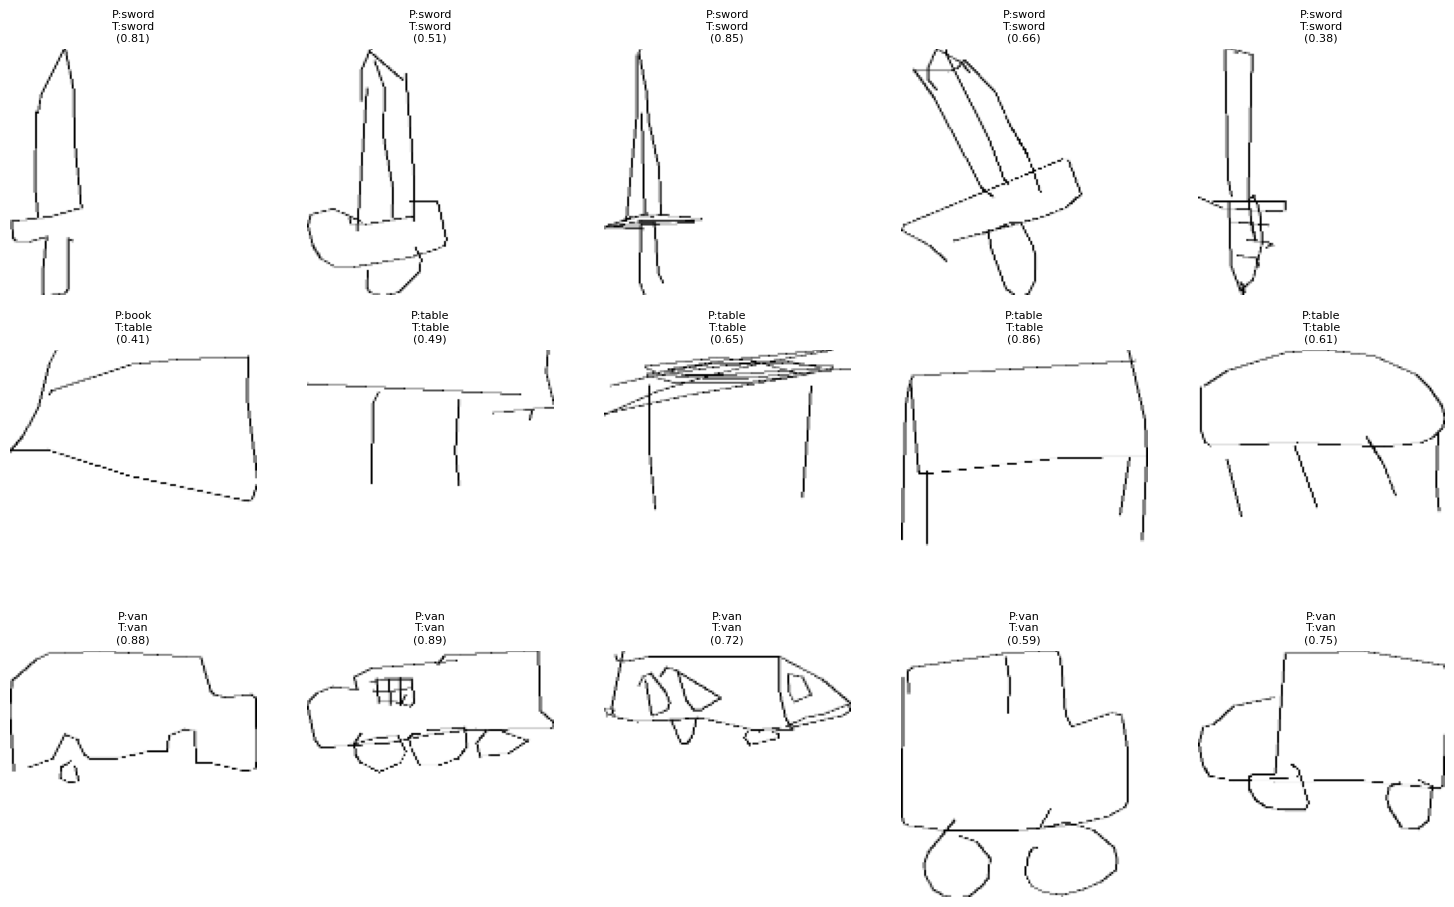

In [8]:
import matplotlib.pyplot as plt

samples_per_class = {cls: [] for cls in class_names}
max_per_class = 5

for images, labels in test_ds:
    preds = model.predict(images)
    pred_idx = np.argmax(preds, axis=1)
    true_idx = np.argmax(labels.numpy(), axis=1)

    for i in range(len(images)):
        cls = class_names[true_idx[i]]
        if len(samples_per_class[cls]) < max_per_class:
            samples_per_class[cls].append((
                images[i].numpy(),
                true_idx[i],
                pred_idx[i],
                preds[i][pred_idx[i]]
            ))

    if all(len(v) >= max_per_class for v in samples_per_class.values()):
        break

num_classes = len(class_names)
plt.figure(figsize=(15, 3 * num_classes))

for row, cls in enumerate(class_names):
    items = samples_per_class[cls]
    for col in range(len(items)):
        img, true_i, pred_i, conf = items[col]

        plt.subplot(num_classes, max_per_class, row * max_per_class + col + 1)
        plt.imshow(img)
        plt.axis("off")

        pred_label = class_names[pred_i]
        true_label = class_names[true_i]
        title = f"P:{pred_label}\nT:{true_label}\n({conf:.2f})"
        plt.title(title, fontsize=8)

plt.tight_layout()
plt.show()